In [294]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader,random_split
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
import random

In [295]:
IMG_SIZE=32
EMB_DIM=64
ATTENTION_HEAD=4
BATCH_SIZE=12
EPOCHS=100
LR=3e-4
TEMPERATURE=0.07

In [296]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [297]:
#synthetic dataset properties
colors=["red","green","blue","yellow","purple","orange","pink","brown","gray"]
shapes=["square","circle","triangle"]
positions=["left","right","top","bottom","top-left","top-right","bottom-left","bottom-right"]

In [298]:
def draw_sample(color,shape,position,img_size=IMG_SIZE):
  img=Image.new('RGB',(img_size,img_size),'white')
  draw=ImageDraw.Draw(img)
  margin=6
  w=h=img_size-2*margin

  if 'left' in position:
    x0=margin
    x1=margin + w//2

  elif 'top-left' in position:
    x0=margin
    x1=margin + w//2

  elif 'bottom-left' in position:
    x0=margin
    x1=margin + w//2

  elif 'right' in position:
    x0=margin + w//2
    x1=img_size-margin

  elif 'top-right' in position:
    x0=margin + w//2
    x1=img_size-margin

  elif 'bottom-right' in position:
    x0=margin + w//2
    x1=img_size-margin

  else:
    x0=margin+w//4
    x1=margin+w*3//4
    #calculate y coordinate

  if 'top' in position:
    y0=margin
    y1=margin + h//2

  elif 'top-left' in position:
    y0=margin
    y1=margin + h//2

  elif 'top-right' in position:
    y0=margin
    y1=margin + h//2

  elif 'bottom' in position:
    y0=margin + h//2
    y1=img_size-margin

  elif 'bottom-left' in position:
    y0=margin + h//2
    y1=img_size-margin

  elif 'bottom-right' in position:
    y0=margin + h//2
    y1=img_size-margin

  else:
    y0=margin+h//4
    y1=margin+h*3//4

  if shape=='square':
    draw.rectangle((x0,y0,x1,y1),fill=color,outline='black')

  elif shape=='circle':
    draw.ellipse((x0,y0,x1,y1),fill=color,outline='black')

  else:
    draw.polygon([(x0+(x1-x0)//2,y0),(x0,y1),(x1,y1)],fill=color, outline='black')

  return img



In [299]:
class ShapesDataset:
  def __init__(self):
    self.images=[]
    self.captions=[]

    for c in colors:
      for s in shapes:
        for p in positions:
          img=draw_sample(c,s,p)
          caption=f"{c} {s} {p}"
          self.images.append(torch.from_numpy(np.array(img)).permute(2,0,1).float()/255.0)
          self.captions.append(caption)

    self.vocab,self.word2idx=self.build_vocab(self.captions)

  def build_vocab(self,texts):
    unique_words = set()
    for t in texts:
      for w in t.split():
        unique_words.add(w)
    words = sorted(list(unique_words))
    # Ensure '[CLS]' is part of the words used to build word2idx and is at index 0
    all_words_for_idx = ['[CLS]'] + words
    word2idx = {w:i for i,w in enumerate(all_words_for_idx)}
    vocab = all_words_for_idx # The complete vocabulary list

    return vocab,word2idx

  def encoder(self,text):
    tokens=[self.word2idx['[CLS]']]+ [self.word2idx[w] for w in text.split()]
    return torch.tensor(tokens,dtype=torch.long)

  def __len__(self):
    return len(self.images)

  def __getitem__(self,idx):
    return self.images[idx],self.encoder(self.captions[idx])

In [300]:
dataset=ShapesDataset()
VOCAB_SIZE=len(dataset)
print(VOCAB_SIZE)

216


In [301]:
print(dataset.vocab)

['[CLS]', 'blue', 'bottom', 'bottom-left', 'bottom-right', 'brown', 'circle', 'gray', 'green', 'left', 'orange', 'pink', 'purple', 'red', 'right', 'square', 'top', 'top-left', 'top-right', 'triangle', 'yellow']


In [302]:
train_size=int(0.8*len(dataset))
test_size=len(dataset)-train_size
train_ds, test_ds= random_split(dataset,[train_size,test_size])

In [303]:
train_loader=DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True)
test_loader=DataLoader(test_ds,batch_size=BATCH_SIZE,shuffle=False)

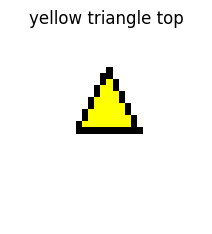

In [304]:
imgs, caps=next(iter(train_loader))
idx=random.randint(0,len(imgs)-1)
img=imgs[idx]
caption_tensor=caps[idx]

img_to_display=(img.permute(1,2,0).numpy()*255).astype(np.uint8)

caption_words = [dataset.vocab[i] for i in caption_tensor.tolist()]
caption_str = " ".join(caption_words[1:]) # Skip '[CLS]' token for display

plt.figure(figsize=(2.5,2.5))
plt.imshow(img_to_display)
plt.title(caption_str)
plt.axis('off')
plt.show()

In [305]:
from torch.nn.modules.conv import Conv2d
class ImageEncoder(nn.Module):
  def __init__(self,emb_dim=EMB_DIM):
    super().__init__()
    self.conv=nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=2,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=2,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=2,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=2,padding=1),
        nn.ReLU()
      )

    self.projection=nn.Linear(256,EMB_DIM)
    self.layer_norm=nn.LayerNorm(EMB_DIM)


  def forward(self,x):
    x=self.conv(x)
    x=x.mean(dim=[2,3])
    x=self.projection(x)
    x=F.normalize(self.layer_norm(x),dim=-1)
    return x


In [306]:
class TextEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.token_emb=nn.Embedding(VOCAB_SIZE,EMB_DIM)
    self.position_emb=nn.Embedding(5,EMB_DIM) #context window =4
    self.mha=nn.MultiheadAttention(EMB_DIM,ATTENTION_HEAD,batch_first=True)
    self.layer_norm=nn.LayerNorm(EMB_DIM)
    self.projection=nn.Linear(EMB_DIM,EMB_DIM)

  def forward(self,tokens):
    N,L=tokens.shape
    position_emb_ids=torch.arange(L,device=device).unsqueeze(0).expand(N,L)
    position_emb_vec=self.position_emb(position_emb_ids)
    token_emb_vec=self.token_emb(tokens)
    final_emb=token_emb_vec+position_emb_vec
    context_vector=self.mha(final_emb,final_emb,final_emb)[0]
    x=context_vector[:,0]
    projection=self.projection(x)
    return F.normalize(self.layer_norm(projection),dim=-1)


In [307]:
def clip_loss(img_emb,text_emb,temperature=TEMPERATURE):
  logits=logits = (img_emb @ text_emb.T) / temperature
  targets=torch.arange(len(img_emb),device=device)
  loss_i=F.cross_entropy(logits,targets)
  loss_t=F.cross_entropy(logits.T,targets)
  return (loss_i+loss_t)/2.0

In [308]:
img_enc=ImageEncoder().to(device)
text_enc=TextEncoder().to(device)
params=list(img_enc.parameters())+list(text_enc.parameters())
optimizer=torch.optim.Adam(params,lr=LR)

In [309]:
from tqdm.notebook import tqdm

def train_epoch(image_encoder, text_encoder, train_dataloader, optimizer, temperature, device):
    image_encoder.train()
    text_encoder.train()
    total_loss = 0
    for imgs, caps in tqdm(train_dataloader, desc="Training"):
        imgs = imgs.to(device)
        caps = caps.to(device)

        img_emb = image_encoder(imgs)
        text_emb = text_encoder(caps)
        loss = clip_loss(img_emb, text_emb, temperature)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_dataloader)

def validate_epoch(image_encoder, text_encoder, val_dataloader, temperature, device):
    image_encoder.eval()
    text_encoder.eval()
    total_loss = 0
    with torch.no_grad():
        for imgs, caps in tqdm(val_dataloader, desc="Validation"):
            imgs = imgs.to(device)
            caps = caps.to(device)

            img_emb = image_encoder(imgs)
            text_emb = text_encoder(caps)
            loss = clip_loss(img_emb, text_emb, temperature)
            total_loss += loss.item()
    return total_loss / len(val_dataloader)

train_losses = []
val_losses = []

print(f"{'Epoch':<10}{'Train Loss':<15}{'Val Loss':<15}")
print("-" * 40)

for epoch in range(EPOCHS):
    train_loss = train_epoch(img_enc, text_enc, train_loader, optimizer, TEMPERATURE, device)
    val_loss = validate_epoch(img_enc, text_enc, test_loader, TEMPERATURE, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"{epoch+1:<10}{train_loss:<15.4f}{val_loss:<15.4f}")


Epoch     Train Loss     Val Loss       
----------------------------------------


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

1         2.4290         2.3631         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

2         2.3102         2.0693         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

3         1.3357         1.0226         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

4         0.8526         0.6849         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

5         0.6497         0.4979         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

6         0.5536         0.4347         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

7         0.5478         0.9290         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

8         0.6898         0.4308         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

9         0.4546         0.3331         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

10        0.3414         0.2905         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

11        0.3733         0.2581         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

12        0.3284         0.4735         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

13        0.4248         0.2961         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

14        0.2372         0.2146         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

15        0.2714         0.1968         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

16        0.2088         0.2698         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

17        0.2545         0.2050         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

18        0.1945         0.1591         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

19        0.1709         0.1542         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

20        0.1359         0.1374         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

21        0.1783         0.1620         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

22        0.1609         0.2158         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

23        0.2168         0.2218         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

24        0.1838         0.2077         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

25        0.1669         0.2126         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

26        0.2174         0.1794         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

27        0.1391         0.1233         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

28        0.0933         0.1223         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

29        0.1202         0.1140         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

30        0.1101         0.1021         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

31        0.0833         0.1117         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

32        0.0884         0.1513         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

33        0.1296         0.0978         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

34        0.0946         0.1202         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

35        0.0975         0.1108         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

36        0.0865         0.0820         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

37        0.0742         0.0779         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

38        0.0713         0.0725         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

39        0.0687         0.0840         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

40        0.0600         0.0683         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

41        0.0621         0.0784         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

42        0.0510         0.0873         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

43        0.0592         0.0890         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

44        0.0498         0.0598         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

45        0.0519         0.0535         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

46        0.0633         0.0802         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

47        0.0622         0.0613         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

48        0.0506         0.0471         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

49        0.0396         0.0553         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

50        0.0456         0.0451         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

51        0.0433         0.0366         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

52        0.0578         0.0414         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

53        0.0256         0.0339         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

54        0.0442         0.0347         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

55        0.0213         0.0445         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

56        0.0365         0.0392         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

57        0.0229         0.0321         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

58        0.0240         0.0298         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

59        0.0331         0.0285         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

60        0.0347         0.0334         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

61        0.0269         0.0375         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

62        0.0371         0.0425         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

63        0.0582         0.0584         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

64        0.0543         0.0298         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

65        0.0422         0.0338         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

66        0.0371         0.0392         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

67        0.0546         0.0334         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

68        0.0377         0.0532         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

69        0.0314         0.0627         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

70        0.0396         0.0746         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

71        0.0398         0.0402         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

72        0.0407         0.0322         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

73        0.0361         0.0514         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

74        0.0655         0.0934         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

75        0.0610         0.0938         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

76        0.0363         0.0863         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

77        0.0446         0.0412         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

78        0.0541         0.0645         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

79        0.0467         0.0384         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

80        0.0324         0.0333         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

81        0.0158         0.0289         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

82        0.0194         0.0290         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

83        0.0287         0.0260         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

84        0.0262         0.0276         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

85        0.0246         0.0264         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

86        0.0356         0.0254         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

87        0.0175         0.0236         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

88        0.0185         0.0259         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

89        0.0247         0.0271         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

90        0.0185         0.0258         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

91        0.0199         0.0295         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

92        0.0201         0.0262         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

93        0.0229         0.0254         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

94        0.0127         0.0249         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

95        0.0151         0.0263         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

96        0.0170         0.0209         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

97        0.0154         0.0220         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

98        0.0125         0.0205         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

99        0.0165         0.0213         


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

100       0.0218         0.0211         


In [310]:
all_img_embeddings = []
all_text_embeddings = []

img_enc.eval()
text_enc.eval()

with torch.no_grad():
    for i in range(len(dataset)):
        img, caption = dataset[i]


        img = img.unsqueeze(0).to(device)
        img_emb = img_enc(img).cpu().numpy()
        all_img_embeddings.append(img_emb)


        caption = caption.unsqueeze(0).to(device)
        text_emb = text_enc(caption).cpu().numpy()
        all_text_embeddings.append(text_emb)

# Concatenate all embeddings into single NumPy arrays
all_img_embeddings_np = np.concatenate(all_img_embeddings, axis=0)
all_text_embeddings_np = np.concatenate(all_text_embeddings, axis=0)

print(f"Shape of all_img_embeddings_np: {all_img_embeddings_np.shape}")
print(f"Shape of all_text_embeddings_np: {all_text_embeddings_np.shape}")

Shape of all_img_embeddings_np: (216, 64)
Shape of all_text_embeddings_np: (216, 64)


In [311]:
def text_to_image_retrieval(text_query, k=5):
    tokenized_query = dataset.encoder(text_query).to(device)
    text_embedding = text_enc(tokenized_query.unsqueeze(0))
    img_embeddings_tensor = torch.from_numpy(all_img_embeddings_np).to(device)
    similarities = (text_embedding @ img_embeddings_tensor.T).squeeze(0)

    top_k_scores, top_k_indices = torch.topk(similarities, k=k)

    return top_k_indices.cpu().detach().numpy(), top_k_scores.cpu().detach().numpy()

Text Query: 'red square left'
Top 5 retrieved images:


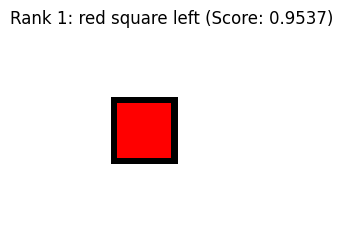

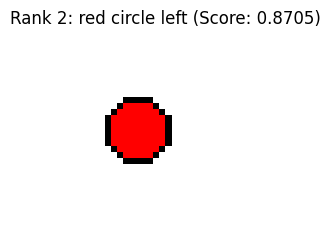

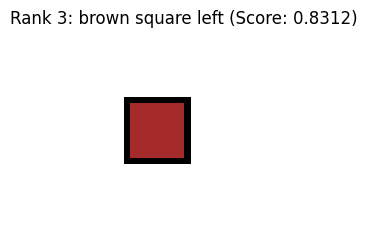

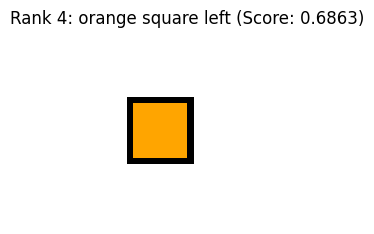

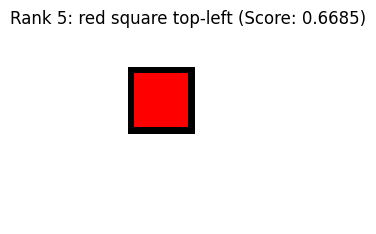

In [312]:
text_query = "red square left"
top_k_indices, top_k_scores = text_to_image_retrieval(text_query, k=5)

print(f"Text Query: '{text_query}'")
print("Top 5 retrieved images:")
for i, (idx, score) in enumerate(zip(top_k_indices, top_k_scores)):
    img_tensor, caption_tensor = dataset[idx]
    img_to_display = (img_tensor.permute(1,2,0).numpy()*255).astype(np.uint8)
    caption_words = [dataset.vocab[w_idx] for w_idx in caption_tensor.tolist()]
    caption_str = " ".join(caption_words[1:]) # Skip '[CLS]' token

    plt.figure(figsize=(2.5,2.5))
    plt.imshow(img_to_display)
    plt.title(f"Rank {i+1}: {caption_str} (Score: {score:.4f})")
    plt.axis('off')
    plt.show()

In [313]:
def image_to_text_retrieval(image_index, k=5):
    img_tensor, _ = dataset[image_index]
    img_embedding = img_enc(img_tensor.unsqueeze(0).to(device))
    text_embeddings_tensor = torch.from_numpy(all_text_embeddings_np).to(device)
    similarities = (img_embedding @ text_embeddings_tensor.T).squeeze(0);

    top_k_scores, top_k_indices = torch.topk(similarities, k=k)

    return top_k_indices.cpu().detach().numpy(), top_k_scores.cpu().detach().numpy()

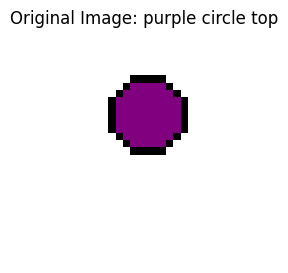


Top 5 retrieved captions for image 'purple circle top':
Rank 1: purple circle top (Score: 0.9432)
Rank 2: blue circle top (Score: 0.7539)
Rank 3: brown circle top (Score: 0.7174)
Rank 4: purple circle right (Score: 0.6343)
Rank 5: blue circle right (Score: 0.5837)


In [314]:
random_image_index = random.randint(0, len(dataset) - 1)

top_k_indices, top_k_scores = image_to_text_retrieval(random_image_index, k=5)

original_img_tensor, original_caption_tensor = dataset[random_image_index]
original_img_to_display = (original_img_tensor.permute(1,2,0).numpy()*255).astype(np.uint8)
original_caption_words = [dataset.vocab[w_idx] for w_idx in original_caption_tensor.tolist()]
original_caption_str = " ".join(original_caption_words[1:])

plt.figure(figsize=(3,3))
plt.imshow(original_img_to_display)
plt.title(f"Original Image: {original_caption_str}")
plt.axis('off')
plt.show()

print(f"\nTop 5 retrieved captions for image '{original_caption_str}':")
for i, (idx, score) in enumerate(zip(top_k_indices, top_k_scores)):
    retrieved_caption_tensor = dataset.captions[idx]
    # The dataset.encoder output includes [CLS], so we need to get the original caption string
    retrieved_caption_str = " ".join([dataset.vocab[w_idx] for w_idx in dataset.encoder(retrieved_caption_tensor).tolist()][1:])
    print(f"Rank {i+1}: {retrieved_caption_str} (Score: {score:.4f})")